In [20]:
!pip install torchinfo
from zipfile import ZipFile

In [ ]:
with ZipFile('/content/drive/MyDrive/extracted_data.zip','r') as zipObj:
  zipObj.extractall('drive/MyDrive/test')

In [1]:
import torch
import torch.nn as nn# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchinfo import summary

import os
import warnings
warnings.filterwarnings('ignore')
import zipfile

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SPLIT = 0.7
LR = 3e-4
PATH = '/kaggle/input/extracted-data/extracted_data'

# LOADING CUSTOM DATASET

In [3]:
DEVICE

'cuda'

In [4]:
class UAVDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB") # multi-channel segmentation

        # using random library to ensure image and mask pairs have the same transformations

        if random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        if random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        if random() > 0.8:
            image = TF.rotate(image, 30)
            mask = TF.rotate(mask, 30)

        image = TF.to_tensor(image)
        image = TF.resize(image,size = (572,572))
        mask = TF.to_tensor(mask)
        mask = TF.resize(mask,size = (274,274))
        return image, mask

In [5]:
os.getcwd()

'/kaggle/working'

In [6]:
os.makedirs('/kaggle/working/saved_model', exist_ok = True) # create library to store saved models

In [7]:
img_dir = PATH + '/image'
mask_dir = PATH + '/mask'
save_model_path = '/kaggle/working/saved_model'

In [8]:
img_dir, mask_dir, save_model_path

('/kaggle/input/extracted-data/extracted_data/image',
 '/kaggle/input/extracted-data/extracted_data/mask',
 '/kaggle/working/saved_model')

In [9]:
data = UAVDataset(img_dir = img_dir, mask_dir = mask_dir)

In [10]:

data.__len__()

215

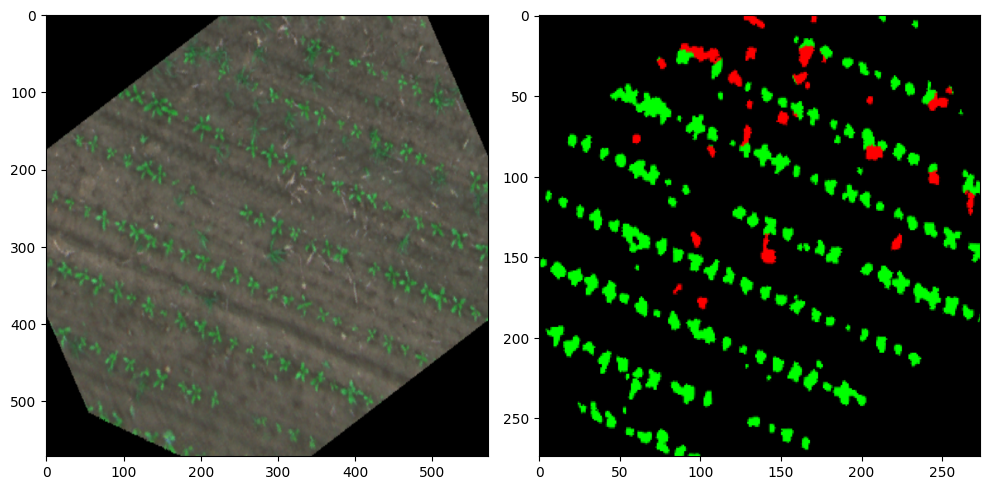

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
image, mask = data[8]
ax[0].imshow(image.permute(1,2,0))
ax[1].imshow(mask.permute(1,2,0))
plt.tight_layout()

In [12]:
image.shape

torch.Size([3, 572, 572])

In [13]:
mask.shape

torch.Size([3, 274, 274])

In [14]:
train_size = int(len(data)*SPLIT)
test_size = len(data) - train_size

trainData, testData = random_split(data, [train_size, test_size])

In [15]:
len(trainData), len(testData)

(150, 65)

In [16]:
trainDL = DataLoader(trainData, batch_size = 8, shuffle = True)
testDL = DataLoader(testData, batch_size = 8, shuffle = False)

In [17]:
len(trainDL), len(testDL)

(19, 9)

In [18]:
for batch in trainDL:
    img, mask = batch
    print(img.size())
    print(mask.size())
    break


torch.Size([8, 3, 572, 572])
torch.Size([8, 3, 274, 274])


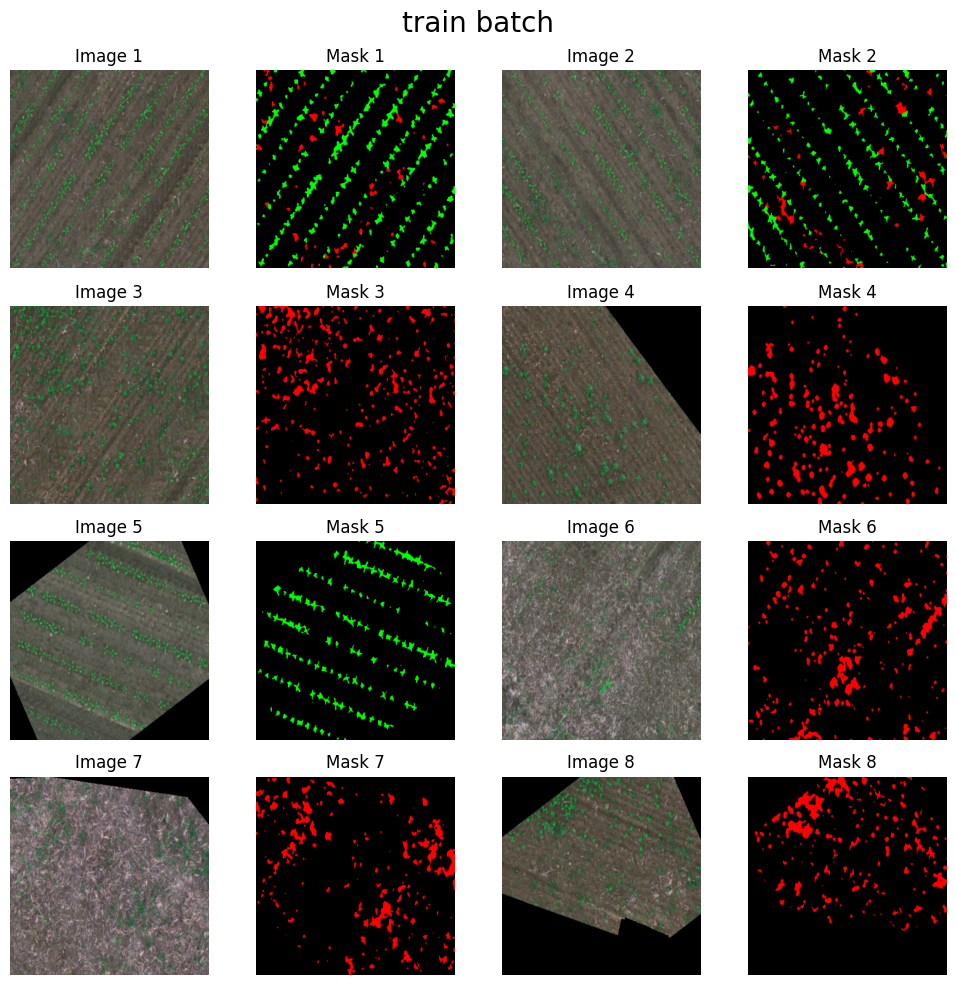

In [19]:
# plot image, mask pairs of the first training batch
for batch_idx, (images, masks) in enumerate(trainDL):
    if batch_idx == 0:
        fig, axs = plt.subplots(4, 4, figsize=(10,10))
        axs = axs.flatten()
        j = 0
        for i in range(8):
            img_np = TF.to_pil_image(images[i])
            mask_np = TF.to_pil_image(masks[i])

            # Plot the image
            axs[j].imshow(img_np)
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')

            # Plot the corresponding mask
            axs[j+1].imshow(mask_np, cmap='gray')
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Mask {i+1}')
            j += 2

        plt.suptitle('train batch', size = 20)
        plt.tight_layout()

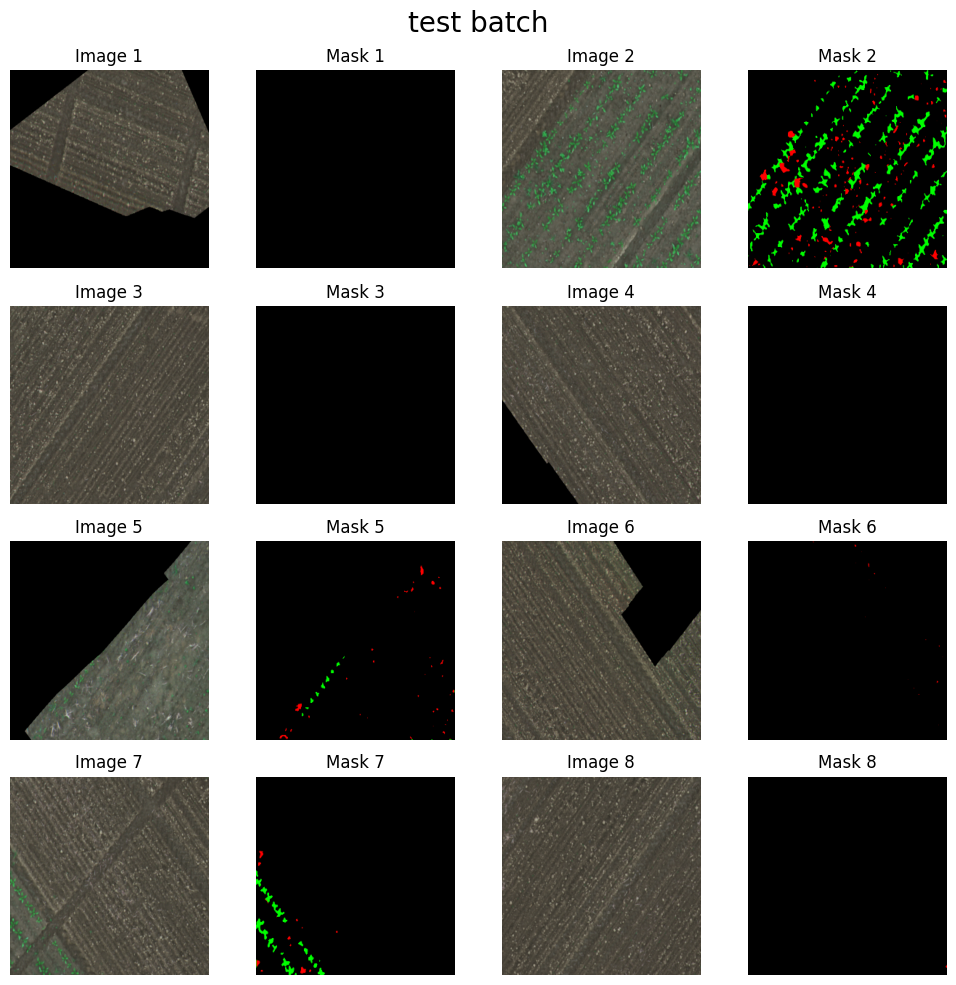

In [20]:
# plot image, mask pairs of the first test batch
for batch_idx, (images, masks) in enumerate(testDL):

    if batch_idx == 0:

        fig, axs = plt.subplots(4, 4, figsize=(10, 10))
        axs = axs.flatten()
        j=0
        for i in range(8):
            img_np = TF.to_pil_image(images[i])
            mask_np = TF.to_pil_image(masks[i])

            # Plot the image
            axs[j].imshow(img_np)
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')

            # Plot the corresponding mask
            axs[j+1].imshow(mask_np, cmap='gray')
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Mask {i+1}')
            j += 2

        plt.suptitle('test batch', size = 20)
        plt.tight_layout()

In [21]:
''' def crop_image(tensor,target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    val = 0
    if(delta%2 != 0):
      val = 1

    delta = delta // 2
    if(val == 1):
      return tensor[:,:,delta:tensor_size-delta-1,delta:tensor_size-delta-1]
    return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta] '''

import torch.nn.functional as F

def crop_image(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = target_size - tensor_size
    padding = [0, 0, 0, 0]  # padding values for top, bottom, left, right

    if delta > 0:
        pad_left = delta // 2
        pad_right = delta - pad_left
        padding = [pad_left, pad_right, pad_left, pad_right]

    return F.pad(tensor, padding)

In [22]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        resnet = models.resnet50(pretrained=True)  # Load pre-trained ResNet50

        # Encoder
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder
        self.up_conv_1 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder_conv_1 = DoubleConv(2048, 1024)

        self.up_conv_2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder_conv_2 = DoubleConv(1024, 512)

        self.up_conv_3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_conv_3 = DoubleConv(512, 256)

        self.up_conv_4 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.decoder_conv_4 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64,3,kernel_size=1)

    def forward(self, x):

      # Encoder


      x1 = self.encoder1(x)
      x2 = self.encoder2(x1)
      x3 = self.encoder3(x2)
      x4 = self.encoder4(x3)
      x5 = self.encoder5(x4)


      # Decoder
      x = self.up_conv_1(x5)
      y = crop_image(x4,x)
      x = self.decoder_conv_1(torch.cat([x,y],1))


      x = self.up_conv_2(x)
      y = crop_image(x,x3)
      x = self.decoder_conv_2(torch.cat([x3,y],1))


      x = self.up_conv_3(x)
      y = crop_image(x,x2)
      x = self.decoder_conv_3(torch.cat([x2,y],1))


      x = self.up_conv_4(x)
      y = crop_image(x1,x)
      x = self.decoder_conv_4(torch.cat([x,y],1))

      x = self.out(x)

      return x

# Define the double convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)



In [23]:
# ensure predicted mask & actual mask have equal dimensions
for batch in trainDL:
    img, mask = batch
    print(mask.shape)
    break
model = UNet().to(DEVICE)
x = img[0].unsqueeze(0).to(DEVICE)
pred = model(x)

print(x.shape)
print(pred.shape)

torch.Size([8, 3, 274, 274])


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s] 


torch.Size([1, 3, 572, 572])
torch.Size([1, 3, 274, 274])


In [24]:
loss_criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [25]:
summary(model, [16, 3, 572, 572])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [16, 3, 274, 274]         --
├─Sequential: 1-1                        [16, 64, 143, 143]        --
│    └─Conv2d: 2-1                       [16, 64, 286, 286]        9,408
│    └─BatchNorm2d: 2-2                  [16, 64, 286, 286]        128
│    └─ReLU: 2-3                         [16, 64, 286, 286]        --
│    └─MaxPool2d: 2-4                    [16, 64, 143, 143]        --
├─Sequential: 1-2                        [16, 256, 143, 143]       --
│    └─Bottleneck: 2-5                   [16, 256, 143, 143]       --
│    │    └─Conv2d: 3-1                  [16, 64, 143, 143]        4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 143, 143]        128
│    │    └─ReLU: 3-3                    [16, 64, 143, 143]        --
│    │    └─Conv2d: 3-4                  [16, 64, 143, 143]        36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 143, 143]        128
│ 

In [26]:
DEVICE

'cuda'

In [27]:
def train_loop(epochs, model, trainDL, testDL, optimizer, loss_criteria):
    trainLossCount = []
    testLossCount = []
    device = next(model.parameters()).device 
    best_test_loss = 10000000
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0

        for batch_idx, (img, mask) in enumerate(trainDL):
            #print(f"Train Batch: {batch_idx}")
            img = img.to(device)
            mask = mask.to(device)
            model.train()
            optimizer.zero_grad()
            pred = model(img)
            loss = loss_criteria(pred, mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(trainDL)

        trainLossCount.append(train_loss)

        with torch.no_grad():
            
            for test_batch_idx, (test_img, test_mask) in enumerate(testDL):
                #print(f"Test Batch: {test_batch_idx}")
                test_img = test_img.to(device)
                test_mask = test_mask.to(device)
                test_pred = model(test_img)
                test_loss += loss_criteria(test_pred, test_mask)

            test_loss /= len(testDL)

            testLossCount.append(test_loss)

        if epoch % 1 == 0:
            print(f"Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")
            if test_loss < best_test_loss:
                print(f"Saving the model. Previous Best Test Loss: {best_test_loss}, Current Test Loss: {test_loss}")
                best_test_loss = test_loss
                torch.save(model.state_dict(), os.path.join(save_model_path, 'model.pth'))

    return trainLossCount, testLossCount

In [28]:
model = model.to("cuda:0")

In [29]:
trainLossCount, testLossCount = train_loop(100, model, trainDL, testDL, optimizer, loss_criteria)

Epoch: 0, Train Loss: 0.5371447331026981, Test Loss: 0.4598456919193268
Saving the model. Previous Best Test Loss: 10000000, Current Test Loss: 0.4598456919193268
Epoch: 1, Train Loss: 0.4249979179156454, Test Loss: 0.39757102727890015
Saving the model. Previous Best Test Loss: 0.4598456919193268, Current Test Loss: 0.39757102727890015
Epoch: 2, Train Loss: 0.38189335245835154, Test Loss: 0.361313134431839
Saving the model. Previous Best Test Loss: 0.39757102727890015, Current Test Loss: 0.361313134431839
Epoch: 3, Train Loss: 0.34167067941866425, Test Loss: 0.3244089186191559
Saving the model. Previous Best Test Loss: 0.361313134431839, Current Test Loss: 0.3244089186191559
Epoch: 4, Train Loss: 0.3079127465423785, Test Loss: 0.2914761006832123
Saving the model. Previous Best Test Loss: 0.3244089186191559, Current Test Loss: 0.2914761006832123
Epoch: 5, Train Loss: 0.27882995574097885, Test Loss: 0.26538124680519104
Saving the model. Previous Best Test Loss: 0.2914761006832123, Curren

# Plotting Loss / Epoch Curve

In [30]:
testLossCount_numpy = []
for loss_tensor in testLossCount:
    # Convert each tensor to a NumPy value
    loss_value = loss_tensor.cpu().numpy()
    testLossCount_numpy.append(loss_value)

# Now testLossCount_numpy is a list of NumPy values representing test losses
print(testLossCount_numpy)

[array(0.4598457, dtype=float32), array(0.39757103, dtype=float32), array(0.36131313, dtype=float32), array(0.32440892, dtype=float32), array(0.2914761, dtype=float32), array(0.26538125, dtype=float32), array(0.2405737, dtype=float32), array(0.22068088, dtype=float32), array(0.20024729, dtype=float32), array(0.18235771, dtype=float32), array(0.16790602, dtype=float32), array(0.15519734, dtype=float32), array(0.14536707, dtype=float32), array(0.13428855, dtype=float32), array(0.12545912, dtype=float32), array(0.11741275, dtype=float32), array(0.10940265, dtype=float32), array(0.10502062, dtype=float32), array(0.09873836, dtype=float32), array(0.0929943, dtype=float32), array(0.08992846, dtype=float32), array(0.0850003, dtype=float32), array(0.08207253, dtype=float32), array(0.07672461, dtype=float32), array(0.07377046, dtype=float32), array(0.07073426, dtype=float32), array(0.06804481, dtype=float32), array(0.06684903, dtype=float32), array(0.06486297, dtype=float32), array(0.06033482, 

In [31]:
testLossList = [loss.tolist() for loss in testLossCount_numpy]


In [32]:
# save loss metrics from training
assert(len(trainLossCount) == len(testLossCount))
np.savez(os.path.join(save_model_path, 'lossCounts'), trainLossCount = trainLossCount, testLossList = testLossList)


In [33]:
load_loss_path ='/kaggle/working/saved_model'
losses = np.load(os.path.join(load_loss_path, 'lossCounts.npz'))

In [34]:
finalTrainLoss = losses['trainLossCount']
finalTestLoss = losses['testLossList']

In [35]:
finalTrainLoss

array([0.53714473, 0.42499792, 0.38189335, 0.34167068, 0.30791275,
       0.27882996, 0.25376578, 0.23154028, 0.2114426 , 0.19179622,
       0.17606439, 0.16135872, 0.14939266, 0.1395559 , 0.12925614,
       0.12073834, 0.11453752, 0.10737534, 0.10128237, 0.09568575,
       0.09246085, 0.08714453, 0.08306416, 0.07887944, 0.07473084,
       0.07202105, 0.06801452, 0.06640508, 0.0647863 , 0.0615417 ,
       0.05813607, 0.05601235, 0.0534769 , 0.05211159, 0.05009518,
       0.0487962 , 0.04698739, 0.04506862, 0.04390924, 0.04218013,
       0.041277  , 0.04306587, 0.03996217, 0.03955362, 0.03774936,
       0.03700864, 0.03668752, 0.03501457, 0.03650593, 0.03576104,
       0.03427717, 0.03269233, 0.032405  , 0.03148692, 0.03113307,
       0.0311753 , 0.03027283, 0.02928427, 0.02866367, 0.03003941,
       0.02912734, 0.02749978, 0.02811238, 0.02670088, 0.02656041,
       0.02728318, 0.02640515, 0.02619938, 0.02736364, 0.0264677 ,
       0.02474332, 0.02453165, 0.02382492, 0.02423081, 0.02520

In [36]:
finalTestLoss

array([0.45984569, 0.39757103, 0.36131313, 0.32440892, 0.2914761 ,
       0.26538125, 0.2405737 , 0.22068088, 0.20024729, 0.18235771,
       0.16790602, 0.15519734, 0.14536707, 0.13428855, 0.12545912,
       0.11741275, 0.10940265, 0.10502062, 0.09873836, 0.0929943 ,
       0.08992846, 0.0850003 , 0.08207253, 0.07672461, 0.07377046,
       0.07073426, 0.06804481, 0.06684903, 0.06486297, 0.06033482,
       0.05820544, 0.05525181, 0.05322194, 0.05169434, 0.04931258,
       0.0484012 , 0.04606082, 0.04509035, 0.04350169, 0.04297772,
       0.04611903, 0.0416032 , 0.04027649, 0.03993644, 0.0395271 ,
       0.03932824, 0.03723926, 0.03830597, 0.03718938, 0.0365051 ,
       0.03488932, 0.03471538, 0.03474691, 0.03437646, 0.03297972,
       0.03346847, 0.03338246, 0.03171921, 0.03242423, 0.03157097,
       0.03302302, 0.0337679 , 0.03172047, 0.03087162, 0.02984224,
       0.0306786 , 0.02964226, 0.02963468, 0.03014011, 0.02899005,
       0.02887662, 0.02958907, 0.03018216, 0.02814612, 0.02934

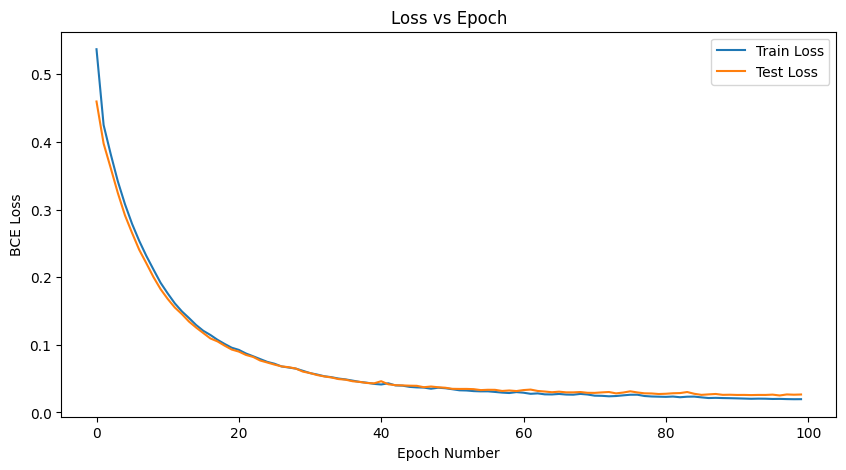

In [37]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(0, len(finalTrainLoss))], finalTrainLoss, label = 'Train Loss')
plt.plot([i for i in range(0, len(finalTestLoss))], finalTestLoss, label = 'Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('BCE Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

# Model Inference

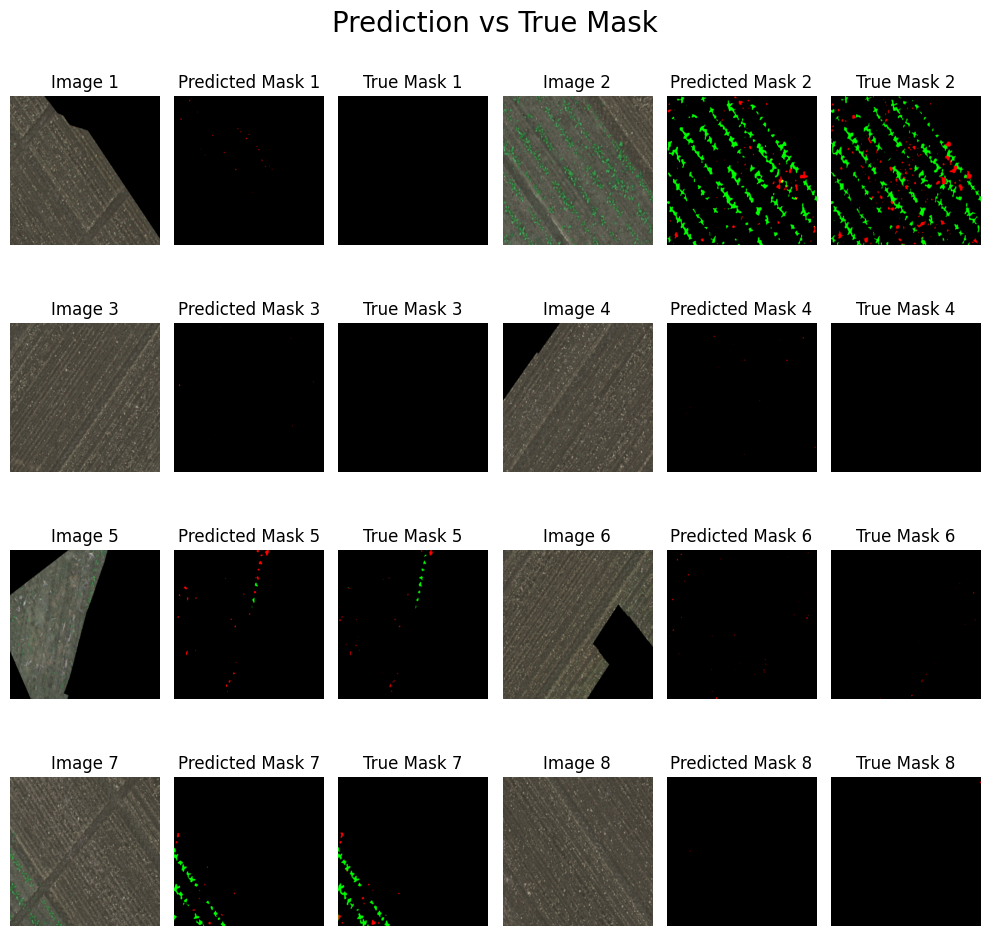

In [40]:
# plot test_batch with true / predicted masks
model = model.to("cuda:1")
for batch_idx, (image, true_mask) in enumerate(testDL):
    
    image = image.to("cuda:1")
    true_mask = true_mask.to("cuda:1")
    if batch_idx == :
        fig, axs = plt.subplots(4, 6, figsize = (10,10))
        axs = axs.flatten()
        pred_mask = model(image)
        j = 0
        for i in range(8):
            
            # Plot the image
            axs[j].imshow(image[i].detach().cpu().numpy().transpose(1,2,0))
            axs[j].axis('off')
            axs[j].set_title(f'Image {i+1}')
            
            # Plot the predicted mask
            axs[j+1].imshow(pred_mask[i].detach().cpu().numpy().transpose(1,2,0))
            axs[j+1].axis('off')
            axs[j+1].set_title(f'Predicted Mask {i+1}')

            # Plot the corresponding mask
            axs[j+2].imshow(true_mask[i].detach().cpu().numpy().transpose(1,2,0))
            axs[j+2].axis('off')
            axs[j+2].set_title(f'True Mask {i+1}')
            j += 3

        plt.suptitle('Prediction vs True Mask', size = 20)
        plt.tight_layout()
        
        
        